# What is the optimal action for short-term FX transactions between SG and MYR?

Imagine the following: 

1. You have to move a non-trivial sum of $$ from SGD to MYR. 
2. This has to happen within the next 12 months. 

This is balanced against the following:
- The funds are currently in a unit trust doing its job. But at the moment, the markets aren't that great....
- If transferred, the funds will then be in a `fixed deposit` or `money market` fund. 

As the responsible adult, you need to make a decision. You want to maximize the net gain such that:

$$
\begin{align}
y = t*r_1 + (d-t)*r_2 + e
\end{align}
$$ 

where
- y: net gain (in %)
- t: time period of time in SGD (in days)
- d: total period of time till funds in needed (in days)
- r1: rate of return in SGD (in days)
- r2: rate of return in MYR (in days)
- e: exchange rate change from present rate (assumeed to be SGD->MYR 3.35)


You are starting to sweat. This decision feels like a game of luck because WHO KNOWS WHAT THE FUTURE HOLDS?! 



## `e`: How volatile are the FX Rates?

The first step is understanding the problem: how volatile are the FX rates? What exactly is at stake? 



In [1]:
# Get the FX rates of SGD->MYR for the past 6 months
import pandas as pd
import pandas_datareader as pdr
import seaborn as sns
import requests
from pprint import pprint

API_URL = "https://www.alphavantage.co/query"
API_KEY = "0SBRTSPM95BI6E5J"

start_date = "2024-03-01"
end_date = "2024-09-01"
parameters = {
    "function": "FX_DAILY",
    "from_symbol": "SGD",
    "to_symbol": "MYR",
    "datatype": "json",
    "apikey": API_KEY,
}

response = requests.get(API_URL,parameters).json()

pprint(
    response["Meta Data"]
)

{'1. Information': 'Forex Daily Prices (open, high, low, close)',
 '2. From Symbol': 'SGD',
 '3. To Symbol': 'MYR',
 '4. Output Size': 'Compact',
 '5. Last Refreshed': '2024-09-13 15:15:00',
 '6. Time Zone': 'UTC'}


In [2]:
import numpy as np
import matplotlib.pyplot as plt

def to_pandas(data):
    time_series = data['Time Series FX (Daily)']
    df = pd.DataFrame.from_dict(time_series).transpose()
    df = df.rename(columns={
        '1. open': 'open', 
        '2. high': 'high', 
        '3. low': 'low', 
        '4. close': 'close'
        })
    
    # Type casting
    for col in df:
        df[col] = df[col].astype(float)
    df.index = pd.to_datetime(df.index)
    
    df.sort_index(ascending=False, inplace=True)

    # Calculate volatility
    df["log_return"] = np.log(df['close'] / df['close'].shift(1))
    df["volatility"] = df["log_return"].rolling(window=3).std()

    print("Processed DF: ")
    print(df.head())
    print(df.tail())


    return df

df = to_pandas(response)

# sns.lineplot(x="date", y="value", data=df)

Processed DF: 
               open     high      low    close  log_return  volatility
2024-09-13  3.32830  3.33060  3.31090  3.31340         NaN         NaN
2024-09-12  3.32693  3.33715  3.31069  3.32633    0.003895         NaN
2024-09-11  3.32092  3.32670  3.31648  3.32305   -0.000987         NaN
2024-09-10  3.32503  3.32942  3.32035  3.32453    0.000445    0.002509
2024-09-09  3.33993  3.34437  3.32103  3.33835    0.004148    0.002650
               open     high      low    close  log_return  volatility
2024-05-05  3.50720  3.50741  3.50382  3.51008    0.001343    0.000136
2024-05-02  3.51005  3.51005  3.49426  3.50727   -0.000801    0.001247
2024-05-01  3.50359  3.50878  3.49547  3.50414   -0.000893    0.001265
2024-04-30  3.48982  3.49013  3.48982  3.49534   -0.002514    0.000964
2024-04-29  3.50376  3.51137  3.49534  3.50349    0.002329    0.002465


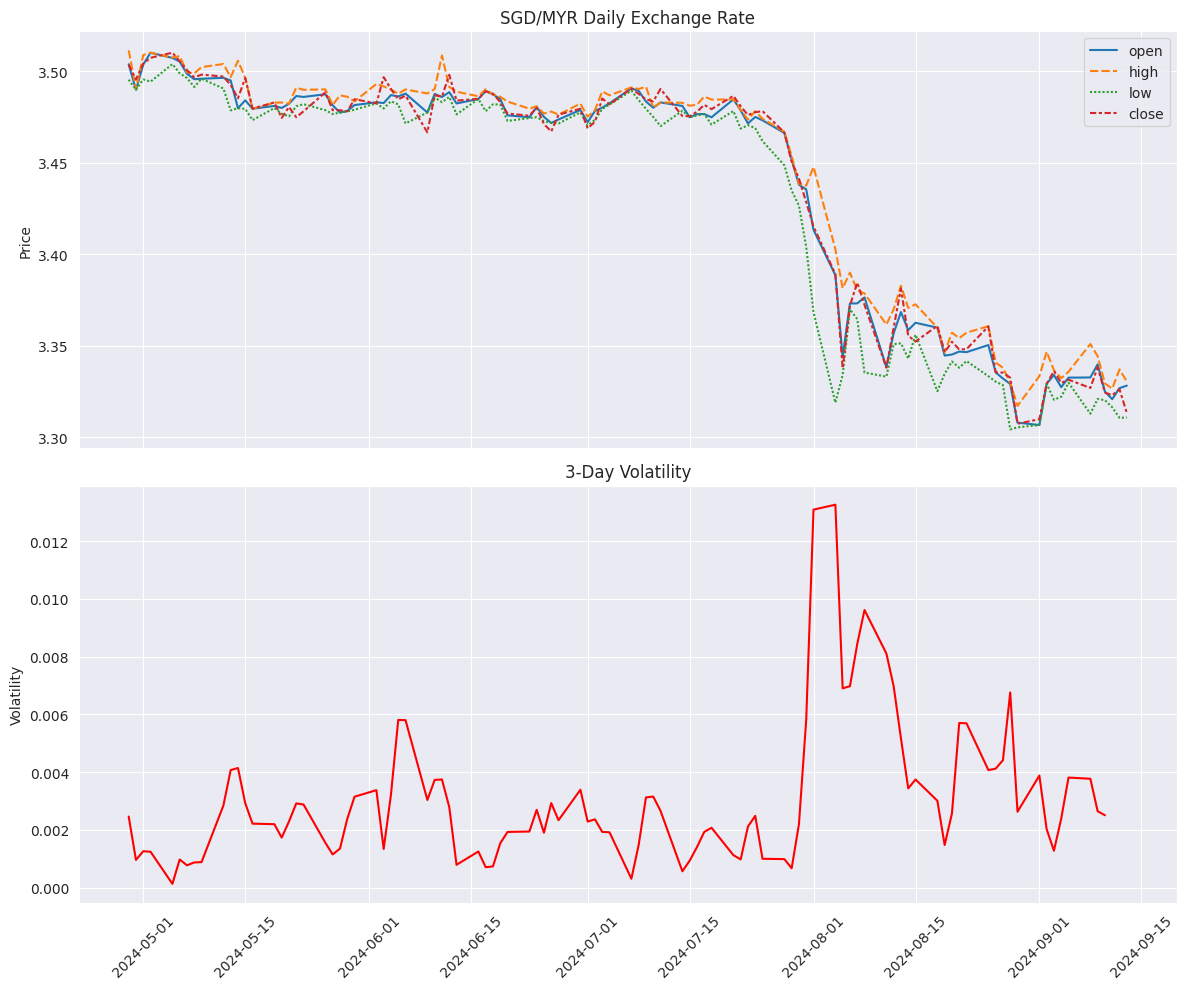

In [3]:
import matplotlib.pyplot as plt
def plot_forex_data(df):
    sns.set_style("darkgrid")
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
    # Plot all price data
    sns.lineplot(data=df[['open', 'high', 'low', 'close']], ax=ax1)
    ax1.set_title('SGD/MYR Daily Exchange Rate')
    ax1.set_ylabel('Price')
    
    # Plot volatility
    sns.lineplot(data=df['volatility'], ax=ax2, color='red')
    ax2.set_title('3-Day Volatility')
    ax2.set_ylabel('Volatility')
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_forex_data(df)


# resample_df_to_weekly()
        index     open     high      low    close
0 2024-05-05  3.50376  3.51137  3.48982  3.51008
1 2024-05-12  3.50524  3.50821  3.49052  3.49703
2 2024-05-19  3.49487  3.50566  3.47325  3.48291
3 2024-05-26  3.47989  3.49097  3.47527  3.48841
4 2024-06-02  3.48133  3.49299  3.47654  3.48239

# melt_df_to_long()
         index variable    value
43 2024-05-26      low  3.47527
49 2024-07-07      low  3.47039
68 2024-06-30    close  3.47945
42 2024-05-19      low  3.47325
14 2024-08-11     open  3.34397
28 2024-06-30     high  3.48226
11 2024-07-21     open  3.47480
53 2024-08-04      low  3.31900
58 2024-09-08      low  3.31298
72 2024-07-28    close  3.46650


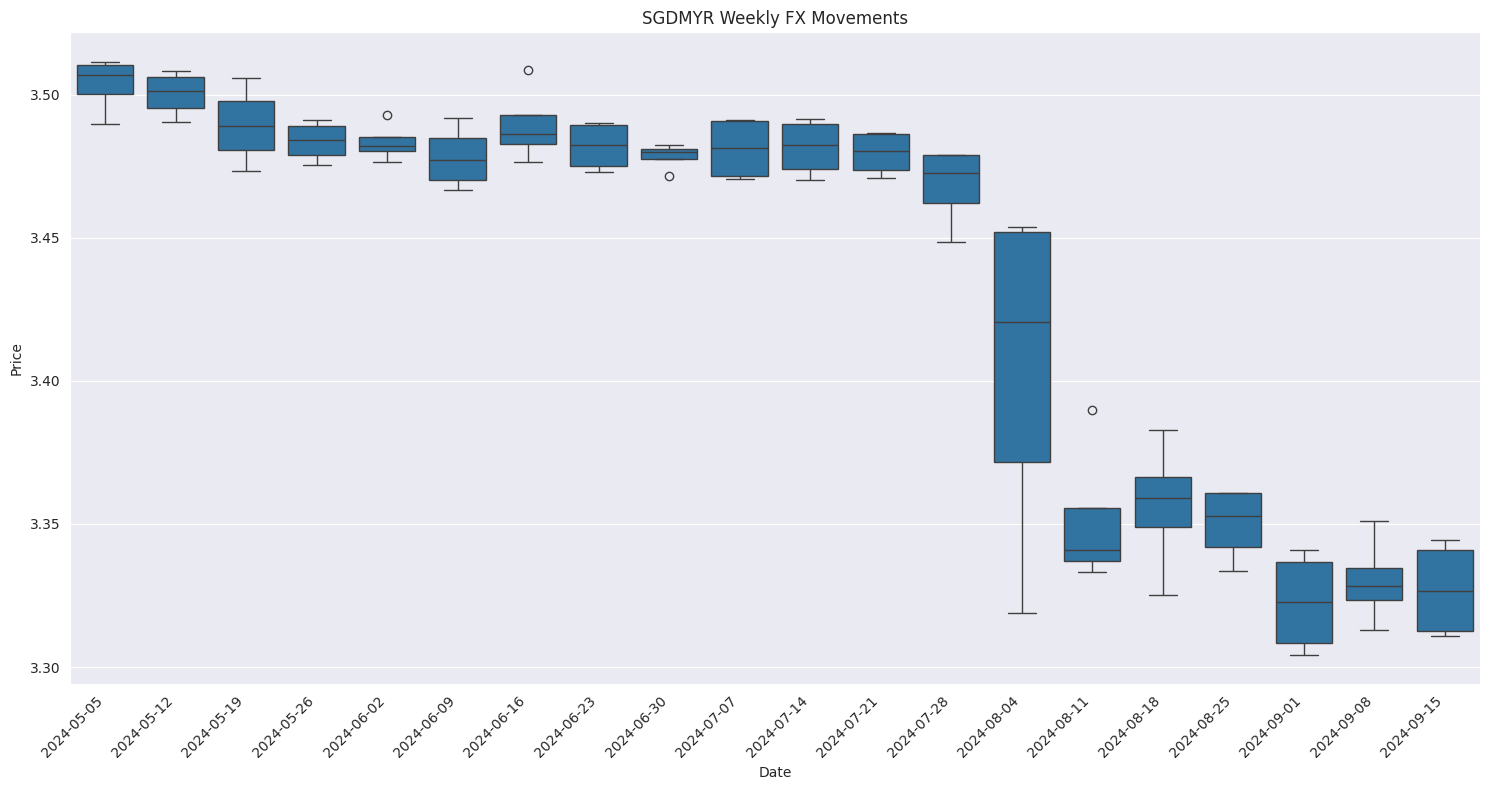

In [4]:
import inspect
import logging

def get_current_function_name():
    return "\n# " + inspect.currentframe().f_back.f_code.co_name + "()\n"

# Resample to weekly frequency
def resample_df_to_weekly(df):
    """
    This code is performing weekly resampling of the DataFrame 'df' and aggregating the data. 

    - df.resample('W'): This method resamples the DataFrame to a weekly frequency. The 'W' argument specifies weekly resampling.
    - .agg({...}): This applies different aggregation functions to specific columns.

    The dictionary inside agg() specifies how each column should be aggregated:
    - 'open': 'first' - Takes the first value of 'open' for each week
    - 'high': 'max' - Takes the maximum value of 'high' for each week
    - 'low': 'min' - Takes the minimum value of 'low' for each week
    - 'close': 'last' - Takes the last value of 'close' for each week
    """
    df = df.resample('W').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last'
    })
    df.reset_index(inplace=True)
    print(get_current_function_name(), df.head() )

    return df


# Melt the dataframe to long format
def melt_df_to_long(df):
    """
    This function takes a DataFrame as input and melts it into a long format.
    
    Key cols returned are: 
    - index: timeseries
    - variable: the melted column name
    - value: the value of the melted column
    """
    df = pd.melt(
    weekly_df,
    id_vars=['index'],
    value_vars=['open', 'high', 'low', 'close']
    )
    print(get_current_function_name(), df.sample(10) )
    return df

weekly_df = resample_df_to_weekly(df)
weekly_long = melt_df_to_long(weekly_df)

# Create the box plot
plt.figure(figsize=(15, 8))
sns.boxplot(data = weekly_long, x = 'index', y = 'value')

plt.title('SGDMYR Weekly FX Movements')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Parameter Estimation

In [5]:
import numpy as np

def estimate_alpha_beta(mode, fx_min, fx_max):
    # Normalize the mode
    m = (mode - fx_min) / (fx_max - fx_min)
    
    # Estimate precision
    k = 2 + (fx_max - fx_min)**(-2)
    
    # Calculate alpha and beta
    alpha = m * (k - 2) + 1
    beta = (1 - m) * (k - 2) + 1
    
    return alpha, beta

# HSBC RM opinion
fx_min, fx_max, mode = 3.25, 3.40, 3.35
alpha, beta = estimate_alpha_beta(mode, fx_min, fx_max)
print(f"Estimated alpha: {alpha:.4f}, Estimated beta: {beta:.4f}")

# Verify the mode
calculated_mode = (alpha - 1) / (alpha + beta - 2)
normalized_input_mode = (mode - fx_min) / (fx_max - fx_min)
print(f"Input normalized mode: {normalized_input_mode:.4f}")
print(f"Calculated normalized mode: {calculated_mode:.4f}")

Estimated alpha: 30.6296, Estimated beta: 15.8148
Input normalized mode: 0.6667
Calculated normalized mode: 0.6667


In [6]:
import numpy as np
from scipy.stats import beta
from scipy.optimize import minimize

def beta_mode(params):
    alpha, beta = params
    return (alpha - 1) / (alpha + beta - 2)

def objective(params, target_mode):
    return (beta_mode(params) - target_mode)**2

def estimate_beta_params_scipy(observed_mode, fx_min, fx_max):
    normalized_mode = (observed_mode - fx_min) / (fx_max - fx_min)
    
    # Initial guess
    initial_guess = [2, 2]
    
    # Optimization
    result = minimize(objective, initial_guess, args=(normalized_mode,), method='Nelder-Mead')
    
    return result.x

# HSBC RM opinion
fx_min, fx_max, mode = 3.25, 3.40, 3.35
alpha_scipy, beta_scipy = estimate_beta_params_scipy(mode, fx_min, fx_max)
print(f"SciPy estimated alpha: {alpha_scipy:.4f}, beta: {beta_scipy:.4f}")

SciPy estimated alpha: 2.3645, beta: 1.6822


## `r`: what can be expected from the investment products?